#### Mohanaditya Karampudi (U69444699)

In [1]:
#Importing required libraries
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import ProbPlot
from sklearn import metrics
from sklearn import ensemble
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import calendar
import re
plt.style.use('seaborn-whitegrid')
warnings.filterwarnings("ignore")
%matplotlib inline

#Calling bokeh packages for plotting
from bokeh.palettes import Spectral6
from bokeh.models import HoverTool
from bokeh.models import LinearInterpolator, CategoricalColorMapper
from bokeh.models import ColumnDataSource
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.models import NumeralTickFormatter
from bokeh.io import output_notebook
from ipywidgets import interact
from bokeh.io import push_notebook
output_notebook()

Loading BokehJS ...

## <font color='blue'>2. Loading data from the server and plotting </font>


In [2]:
#Reading data from the server, data processing, creating new features and removing extreme values
data = pd.read_csv('Building_Permits.csv', low_memory=False)
backup_data = data #creating a backup dataframe for safety

In [3]:
backup_data.columns

Index(['X', 'Y', 'OBJECTID', 'permittypemapped', 'permitnum', 'workclass',
       'permitclass', 'proposedworkdescription', 'permitclassmapped',
       'applieddate', 'issueddate', 'estprojectcost', 'constcompletedofficial',
       'censuslanduse', 'censuslandusecode', 'devplanid', 'corlotid',
       'cntyacctnum', 'coissueddate', 'cocissueddate', 'cocnbr',
       'contractorcompanyname', 'contractordba', 'contractoraddress1',
       'contractoraddress2', 'contractorcity', 'contractorstate',
       'contractoremail', 'contractorlicnum', 'contractorphone',
       'contractorzip', 'countylocation', 'description', 'expirednewpermnum',
       'expiresdate', 'fee', 'fiscalyear', 'govtownedprop', 'grouptenantname',
       'housingunitstotal', 'housingunitsexist', 'issueddate_mth',
       'issueddate_yr', 'jurisdiction', 'jurisdiction_atissue',
       'jurisdiction_inout_ral', 'landusedescription', 'landusenewuse',
       'latitude_perm', 'longitude_perm', 'mapsheet', 'numberstories',
       

In [4]:
backup_data.shape

(141953, 87)

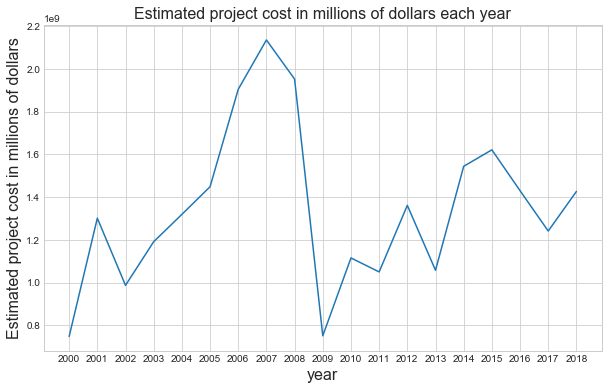

In [5]:
cons_data = backup_data
time_est = cons_data[["estprojectcost","issueddate_yr"]]
time_est.dropna(inplace=True)
time_data = time_est.groupby(["issueddate_yr"]).sum()
plt.figure(figsize=(10,6))
plt.plot(time_data.index,time_data.estprojectcost)
plt.xticks(time_data.index)
plt.title("Estimated project cost in millions of dollars each year",fontsize=16)
plt.ylabel('Estimated project cost in millions of dollars', fontsize=16)
plt.xlabel('year', fontsize=16)
plt.show()

#### <font color='green'>Analysis from Graph </font>

This is a powerful plot which shows the **HOUSING BUBBLE RECESSION**. The number of projects sanctioned were high during the years 2002 till 2007 and because of this the estimated project cost is also high. 

Once the recession started we see a steep drop in the estimated project costs cause there was no finance to create new buildings and on-going constructions came to halt. After the end of recession (2009) the market slowly started recovering (the upward curve).

# <font color='purple'>Exploratory Data Analysis</font>

In [6]:
cons_data.originalcity.value_counts()

RALEIGH          141071
WAKE FOREST         335
GARNER              258
None                151
MORRISVILLE         118
APEX                 11
KNIGHTDALE            3
CARY                  2
ROLESVILLE            2
HOLLY SPRINGS         1
FUQUAY VARINA         1
Name: originalcity, dtype: int64

### The data is of Raleigh city along with the neighboring places

### <font color='blue'>3a. Number of rows and columns in the dataset </font>

In [7]:
print("The number of rows in this dataset are:", cons_data.shape[0])
print("The number of columns in this dataset are:", cons_data.shape[1])
print("Total number of NA values in whole dataframe: ", cons_data.isna().sum().sum())

The number of rows in this dataset are: 141953
The number of columns in this dataset are: 87
Total number of NA values in whole dataframe:  2107710


#### This dataset contains Astonishing NA values.
   Right now my focus is to clear the NA values of the needed columns
#### There are 87 columns and it seems intimidating to have all these columns in just one dataframe. 
So, I have divided the dataframe into multiple based on the names of columns.
We can merge them in future again to derive values or analysis.
The primary intention of this breakdown is to slowly get picture of all these attributes

In [8]:
#Moving all the dates columns to date_columns dataframe
date_columns = cons_data.loc[:, (cons_data.columns.str.contains('Date') | cons_data.columns.str.contains('date') )]

# Moving all the contractor details into a new Dataframe
contractor_details = cons_data.loc[:, cons_data.columns.str.contains('contractor')]

# Moving columns having original details
original_details = cons_data.loc[:, cons_data.columns.str.contains('original')]

#Dropping these columns from the main dataframe
dropping_columns = date_columns.columns, contractor_details.columns, original_details.columns
dropping_columns_flat = [item for sublist in dropping_columns for item in sublist]
cons_data.drop(dropping_columns_flat, axis=1, inplace=True)

### <font color='blue'>3b. Total different types of constructions </font>

The type of building seems new to me as I dont know what these roman letters depict.

A quick google search revealed that these are **FIRE-RESISTANCE RATING** 🔥

• Type I– Commonly referred to as fire-resistive construction

• Type II– Commonly referred to as non-combustible construction

• Type III– Commonly referred to as ordinary construction

• Type IV – Commonly referred to as heavy-timber construction

• Type V– Commonly referred to as wood-frame construction

More information about this can be found here https://codes.iccsafe.org/public/document/code/542/9670120

In [9]:
#There are 7862 rows which do not have any value in the construction type column
print(cons_data.const_type.isna().sum(),"buildings do not have any construction type which is",
      (round((7862/cons_data.shape[0])*100)),"percent of total rows")

7862 buildings do not have any construction type which is 6 percent of total rows


In [10]:
building_fire_type = cons_data.const_type.value_counts()
for i,j in zip(building_fire_type.index, building_fire_type):
    print( "The number of buidings with construction type ", i, "-", j)

The number of buidings with construction type  V  B - 89641
The number of buidings with construction type  VI U - 18381
The number of buidings with construction type  II B - 11710
The number of buidings with construction type  I  B - 2658
The number of buidings with construction type  I  A - 2139
The number of buidings with construction type  IV U - 2028
The number of buidings with construction type  II A - 1907
The number of buidings with construction type  IIIB - 1851
The number of buidings with construction type  V  A - 1818
The number of buidings with construction type  VI P - 428
The number of buidings with construction type  II - 385
The number of buidings with construction type  IV P - 367
The number of buidings with construction type  IIIA - 237
The number of buidings with construction type  V  U - 223
The number of buidings with construction type  I - 122
The number of buidings with construction type  IV - 119
The number of buidings with construction type  V  P - 52
The number

We can clean this further and make only five types of rating by excluding the sub categories in roman

In [11]:
building_fire_type =building_fire_type.reset_index()
building_fire_type.columns = ["fire_type","freq"]
building_fire_type['roman_letter'] = building_fire_type['fire_type'].str.split(' ').str[0]
j = []
for i in building_fire_type.roman_letter:
    
    if len(i)>3:
        j.append(i[0:3])
    else:
        j.append(i)   
building_fire_type['roman_letter'] = j

roman_freq = building_fire_type.groupby('roman_letter').sum()
roman_freq['percentage'] = (roman_freq.freq/cons_data.shape[0]) *100
roman_freq['percentage'] = roman_freq.percentage.round(2)

for i,j,k in zip(roman_freq.index, roman_freq.freq, roman_freq.percentage):
    print( "The number of buidings with construction type ", i, "-", j, "account for ", 
          k, "percentage of total construction")

The number of buidings with construction type  I - 4919 account for  3.47 percentage of total construction
The number of buidings with construction type  II - 14002 account for  9.86 percentage of total construction
The number of buidings with construction type  III - 2113 account for  1.49 percentage of total construction
The number of buidings with construction type  IV - 2514 account for  1.77 percentage of total construction
The number of buidings with construction type  V - 91734 account for  64.62 percentage of total construction
The number of buidings with construction type  VI - 18809 account for  13.25 percentage of total construction


#### <font color='green'>Analysis from Output </font>

The maximum number of constructions are grade five with 91734 houses/constructions, which account upto 65% of the construction type (As type V typically contains the residential houses, it is accounting for maximum share)

The least amount of contruction type is III with a mere 1.49 percent(there are very less ORDINARY Construction type in Raleigh area)

Interesting to see type VI construction type which I did not find in any online article

### <font color='blue'>3c: Mean and median number of stories</font>

In [12]:
print(cons_data.numberstories.isna().sum(),"buildings do not have data of the number of stories which account",
      (round((cons_data.numberstories.isna().sum()/cons_data.shape[0])*100)),"percent of total rows")

19511 buildings do not have data of the number of stories which account 14.0 percent of total rows


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


count    122442.000000
mean          9.707421
std        1114.892012
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max      342365.000000
Name: numberstories, dtype: float64

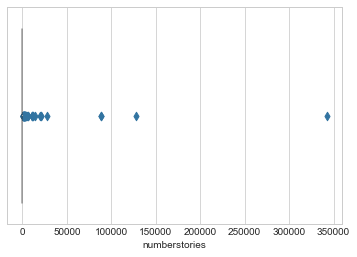

In [13]:
#boxplot just shows a vertical line because outliers have changed the x-axis range
sns.boxenplot(cons_data.numberstories.dropna())
cons_data.numberstories.describe()

In [14]:
print("There are", cons_data.numberstories.value_counts()[1] + cons_data.numberstories.value_counts()[2] ,
      "buildings having one or two floors which account", 
      round(((cons_data.numberstories.value_counts()[1] + cons_data.numberstories.value_counts()[1])/cons_data.shape[0])*100),"percentage \
of total buildings")

There are 102271 buildings having one or two floors which account 57.0 percentage of total buildings


#### <font color='green'>Analysis from Output </font>

All these numbers and graphs show that there is data issue for the number of stories column. Cause the tallest building Burj Khalifa has 163 floors and our data shows 342,000 stories (This is a serious issue) 

    1.The highest number of floors in Raleigh city is 32 (PNC plaza)
    2.The 25th and 75the percentile tells that more than 50% buildings contain either 1 or 2 floors, with a median of 2 floors
    3.The mean value is 9.7. These metrics are not realistic as they are effected by outliers. The boxplot clearly shows the skewness because of the extreme points
    
#### Solution: Try to investigate why we have such unintended values in the number of stories column

### <font color='blue'>3d: Standard deviation for the X and Y coordinates of the permits </font>
The latitude of Raleigh is 35.787743 and the longitude is -78.6442. Hence, the assumption is that there wont be much deviations or variations in the data of X and Y column

In [15]:
cons_data[["X","Y"]].describe()

,X,Y
count,141830.000000,141830.000000
mean,-78.635798,35.835300
std,0.068805,0.058392
min,-78.816616,33.956035
25%,-78.681172,35.788197
50%,-78.637151,35.834122
75%,-78.577937,35.885177
max,-78.490945,35.970246


[Text(0, 0.5, 'Frequency'), Text(0.5, 1.0, 'Distribution of Y coordinates')]

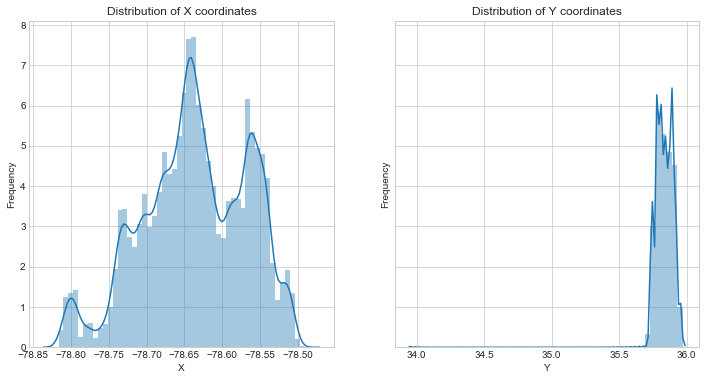

In [16]:
#distribution of X and Y co-ordinates
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(12, 6)
sns.distplot(cons_data.X.dropna(),ax=ax1)
sns.distplot(cons_data.Y.dropna(),ax=ax2)
ax1.set(ylabel='Frequency',title="Distribution of X coordinates") 
ax2.set(ylabel='Frequency',title="Distribution of Y coordinates") 

In [17]:
#few summary metrics
cons_data.X.describe()
print("Difference between maximum and minimum value of X co-ordinates is ",cons_data.X.max()-cons_data.X.min())
print("Difference between maximum and minimum value of Y co-ordinates is ",cons_data.Y.max()-cons_data.Y.min())

Difference between maximum and minimum value of X co-ordinates is  0.3256715894193576
Difference between maximum and minimum value of Y co-ordinates is  2.014211497621062


#### <font color='green'>Analysis from Output </font>

More number of buildings are situated near -78.64 longitutde

With a Difference of 0.3256 between the minimum and maximum value of X column, we can say that the variance is less. This intern implies that the standard deviation will be very minute (std 0.0688)

**The standard deviation of X and Y show that the area operated is higher in terms of north and south distance rather than east and west as the variation in Y coordinates is higher than X coordinates**

### <font color='blue'>4: Plotting Estimated Project Cost and Issue Date Month Attributes</font>

In [18]:
#Distribution of data
cons_data["issueddate_yr"] = date_columns["issueddate_yr"]
cons_data[["issueddate_yr","estprojectcost"]].describe()

,issueddate_yr,estprojectcost
count,138519.000000,1.419530e+05
mean,2008.795176,1.920127e+05
std,5.486947,1.493678e+06
min,2000.000000,0.000000e+00
25%,2004.000000,1.000000e+04
50%,2008.000000,5.440400e+04
75%,2014.000000,1.350000e+05
max,2018.000000,1.700000e+08


In [19]:
# Dividing it with 1000 to see better numbers and interpret in thousands of dollars
cons_data["estprojectcost"] = cons_data.estprojectcost/1000
cons_data.estprojectcost.describe()

count    141953.000000
mean        192.012747
std        1493.678429
min           0.000000
25%          10.000000
50%          54.404000
75%         135.000000
max      170000.000000
Name: estprojectcost, dtype: float64

In [20]:
#I believe having zero is not acceptable. Hence I will remove rows containing zero and perform analysis
print("number of buildings having zero estimated cost:",cons_data[cons_data.estprojectcost == 0].shape[0])
est_data = cons_data[cons_data.estprojectcost != 0]

number of buildings having zero estimated cost: 5917


[Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Distribution of estimated project after removing outliers')]

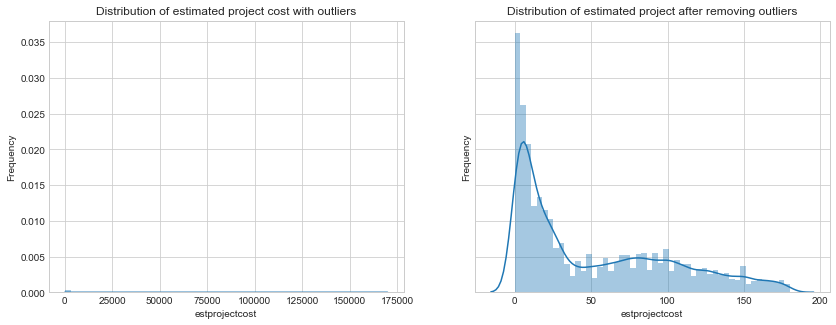

In [21]:
# We see a small hump near 0 of the X-axis which have outliers. Hence changing the x axis range will help
#get better perspective
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(14, 5)
est_data_no_na = est_data.estprojectcost.dropna()
est_data_no_na = est_data_no_na[est_data_no_na < 180]
sns.distplot(est_data.estprojectcost.dropna(),ax=ax1)
sns.distplot(est_data_no_na.dropna(),ax=ax2)
ax1.set(ylabel='Frequency',title="Distribution of estimated project cost with outliers") 
ax2.set(ylabel='Frequency',title="Distribution of estimated project after removing outliers") 

Text(0.5, 0, 'Month')

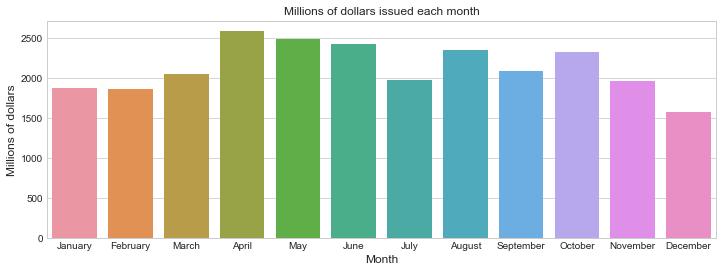

In [22]:
#creating a plot to see in which month more number of estimated projectcost were issued 
plt.figure(figsize=(12,4))
date_estcost= pd.DataFrame()
date_estcost["estprojectcost"] = cons_data["estprojectcost"]
date_estcost["month"] = date_columns["issueddate_mth"]
date_estcost.dropna(inplace=True)
total_est_cost = date_estcost.groupby("month").sum().reset_index()
total_est_cost['estprojectcost'] = total_est_cost['estprojectcost'] / 1000
total_est_cost['monthName'] = total_est_cost.month.astype(int).apply(lambda x: calendar.month_name[x])
ax = sns.barplot(total_est_cost.monthName, total_est_cost.estprojectcost)
plt.title("Millions of dollars issued each month")
plt.ylabel('Millions of dollars', fontsize=12)
plt.xlabel('Month', fontsize=12)

#### <font color='green'>Analysis from Output </font>

    1. The distribution plot shows that this column is highly skewed to right. Which means there are constructions
    that cost a lot more than others.
    2. 75 % of the projects costed between 1 to 135 thousand dollars, with a mean of 54 thousand dollars
    3. The minimum cost is 0 and maximum cost is whooping 170 million dollars.
    4. The quartiles of year show that there are more number of projects sanctioned during 2000 to 2008 than
    from 2008 to 2018
    
The bar plot shows the cumulative amount of estimated millions of dollars spend in each month inrespective of year

    1.The April month is the active construction month and december is the time when least productive work happen (cause it is christmas time)

### <font color='blue'>5. A hypothetical executive team is interested in the behavior between Permit Issue Year and Estimated Project Cost</font>


For the "New" construction work class, with a construction type of "V B", and with less than 3 stories. Perform a simple regression analysis of this relationship and describe what insights we can gleam from this using success metrics. 

In [23]:
#bringing the data back to a single column
cons_data["issueddate_yr"] = date_columns.issueddate_yr
cons_data['estprojectcost'] = cons_data["estprojectcost"]*1000

In [24]:
# subsetting the data containing 
# new_building in workclass column
# V B in construction type column
# number of stories less than 3 in numberstories column

building_subset = cons_data[(cons_data['workclass'].str.contains("New Building",case=False)== True) &
                           (cons_data["const_type"].str.contains("V  B")==True) &
                            (cons_data["numberstories"] < 3)]

In [25]:
building_subset.shape

(31056, 62)

#### We have enough number of samples to perform a regression analysis

In [26]:
#taking the subset of column we want
building_subset.drop(building_subset.columns.difference(['issueddate_yr','estprojectcost']), 1, inplace=True)
building_subset.reset_index(inplace=True, drop=True)

In [27]:
#We have 193 NA values in issued year column
print("The number of NA values  in issue_yr column", building_subset.issueddate_yr.isna().sum(),
     "which is ", building_subset.issueddate_yr.isna().sum()/building_subset.shape[0] ,"percentage" )

NA_rows = building_subset[building_subset.isna().any(axis=1)]
oneplus_NA = NA_rows.index + 1
oneminus_NA = NA_rows.index - 1

upper_value = []
lower_value = []
for i,j in zip(oneplus_NA, oneminus_NA):
    try:
#         print(building_subset.iloc[i][1])
        upper_value.append(building_subset.iloc[i][1])
        lower_value.append(building_subset.iloc[j][1])
    except:
        continue
NA_rows["upper_value"] = upper_value
NA_rows["lower_value"] = lower_value
NA_rows['NEWcolumn'] = NA_rows['upper_value'] == NA_rows["lower_value"]

NA_rows.NEWcolumn.value_counts()

The number of NA values  in issue_yr column 193 which is  0.006214580113343637 percentage


False    127
True      66
Name: NEWcolumn, dtype: int64

###  193 rows have NA values which is less than 0.5 % of whole dataset.
So, we can either drop the rows or impute. I chose imputing

Out of 193 NA value rows, 66 NA values contain same year on the above and below row.
#### I have replaced the NA values with an assumption that the NA is actually the value on its above row

example: If there is NA value on 25th index then the 26th index and 24th index will have same issue year. 
There are 66 such matching indexes.

There are different ways to handle missing values:

    A constant value that has meaning within the domain, such as 0, distinct from all other values.
    A value from another randomly selected record.
    A mean, median or mode value for the column.
    A value estimated by another predictive model.


In [28]:
#replacing NA values with the above row
building_subset.issueddate_yr.fillna(method='ffill', inplace=True)

In [29]:
building_subset['estprojectcost'] = building_subset.estprojectcost.astype(float)
building_subset['issueddate_yr'] = building_subset.issueddate_yr.astype(int)
#There are outliers for sure
building_subset.estprojectcost.describe() 

count    3.105600e+04
mean     2.119560e+05
std      8.760676e+05
min      0.000000e+00
25%      9.820800e+04
50%      1.500000e+05
75%      2.562760e+05
max      1.000000e+08
Name: estprojectcost, dtype: float64

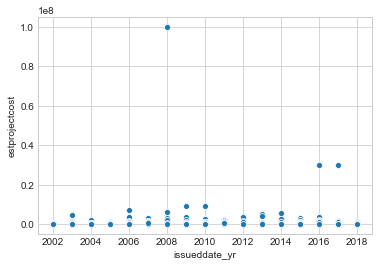

In [30]:
sns.scatterplot(building_subset.issueddate_yr, building_subset.estprojectcost)
#This scatterplot clearly shows that there are outliers whose value is wayy more than other points.
#One of the reason might be the Raleigh created a defying buillding that has costed 100 million dollars
#or there might be error in data
# Two other ouliers show values around  30 million

### Corelation Matrix

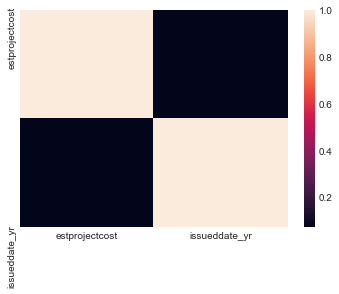

In [31]:
X_y = building_subset[["estprojectcost","issueddate_yr"]]
corr = X_y.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### The corelation plot shows least amount of relation between issue date and estimated project cost. So the linear regression will have high error

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         estprojectcost   R-squared (uncentered):                   0.055
Model:                            OLS   Adj. R-squared (uncentered):              0.055
Method:                 Least Squares   F-statistic:                              1820.
Date:                Wed, 09 Oct 2019   Prob (F-statistic):                        0.00
Time:                        10:29:11   Log-Likelihood:                     -4.6901e+05
No. Observations:               31056   AIC:                                  9.380e+05
Df Residuals:                   31055   BIC:                                  9.380e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
issueddate_yr   105.6052      2.475     42.667      0.000     100.754     110.457
==============================================================================
Omnibus:                   122958.473   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     155776531083.867
Skew:                          99.138   Prob(JB):                         0.00
Kurtosis:                   10973.160   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

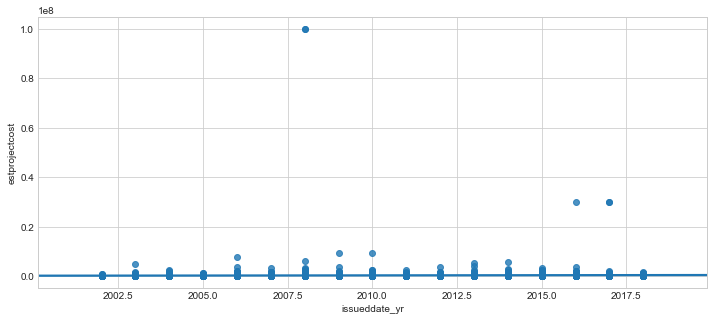

In [32]:
#fitting a model
model_fit = sm.OLS(X_y.estprojectcost,X_y.issueddate_yr).fit()
plt.figure(figsize=(12,5))
sns.regplot(X_y.issueddate_yr, X_y.estprojectcost)
model_fit.summary()

#### <font color='green'>Analysis from Output </font>

##### We see the Adj- R2 value is 0.055 which means there is just 5 % explainability of Estimated project cost from issue data year.
Hence lets improve data by a bit and re-apply the regression

The above plot shows the regression line and can conclude that the line seems horizontal as the Y axis  range is soo huge that the line although has positive slope we are unable to view. So removing outliers will make it more clear

#### Outlier Removal:Removing the rows having estimated project cost value greater than Three Inter-Quartile Range
This is because the outlier skew linear regression equation and increases the error.

Also in real world the frequency of outliers will be less when compared with normal other data points

So removing  outliers (high leverage points) is the best thing to have a **generalized model**

In [33]:
# I chose 3*IQR dollar as the threshold cause from the above scatter plot I see three points which have value greater than 200000
#There are different ways to remove outliers based on threshold 
# 1. Cooks distance
# 2. Inter quartile range
# 3. Z-score
Q1 = building_subset.estprojectcost.quantile(0.25)
Q3 = building_subset.estprojectcost.quantile(0.75)
IQR = Q3 - Q1
building_subset = building_subset[building_subset.estprojectcost < 3*IQR]

In [34]:
IQR

158068.0

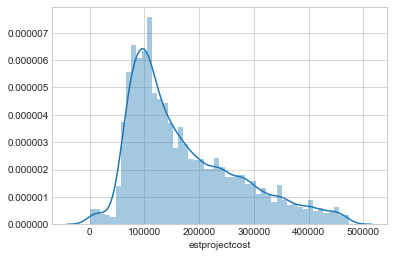

In [35]:
sns.distplot(building_subset.estprojectcost)
#This plot shows a skewed right distribution
#Although we expect data to be normally distributed, it is not the case in real world

In [36]:
X = building_subset[["issueddate_yr"]]
y = building_subset[["estprojectcost"]]
X_train, X_test ,y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
X_y = building_subset[["estprojectcost","issueddate_yr"]]
corr = X_y.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Linear regression line on data


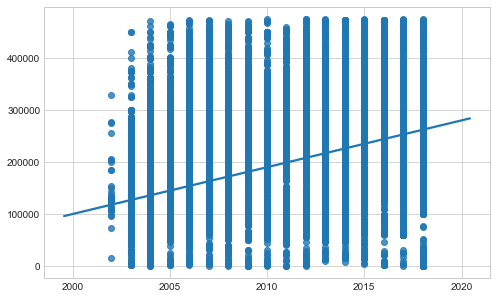

In [37]:
try:
    plt.figure(figsize=(8,5))
    sns.regplot(X_train, y_train)
except ValueError:
    print("Linear regression line on data")

In [38]:
#fitting a model
model_fit = sm.OLS(y_train,X_train).fit()
# Print out the statistics
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         estprojectcost   R-squared (uncentered):                   0.750
Model:                            OLS   Adj. R-squared (uncentered):              0.750
Method:                 Least Squares   F-statistic:                          7.029e+04
Date:                Wed, 09 Oct 2019   Prob (F-statistic):                        0.00
Time:                        10:29:19   Log-Likelihood:                     -3.0386e+05
No. Observations:               23489   AIC:                                  6.077e+05
Df Residuals:                   23488   BIC:                                  6.077e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
issueddate_yr    86.5210      0.326    265.120      0.000      85.881      87.161
==============================================================================
Omnibus:                     2515.921   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3423.281
Skew:                           0.933   Prob(JB):                         0.00
Kurtosis:                       3.121   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
#Model Error
y_train_pred = model_fit.predict(X_train)
y_test_pred = model_fit.predict(X_test)
print('Mean Squared Error on train dataset :', metrics.mean_squared_error(y_train.estprojectcost, y_train_pred)) 
print('Mean Squared Error on test dataset :', metrics.mean_squared_error(y_test.estprojectcost, y_test_pred)) 

Mean Squared Error on train dataset : 10088785701.383757
Mean Squared Error on test dataset : 9960781424.554575


Mean Squared Error of GBM on train dataset : 1603198216.8985007
Mean Squared Error of GBMon test dataset : 1650848128.4691439

Mean Squared Error of GBM on train dataset : 1125513024.294395
Mean Squared Error of GBMon test dataset : 1490281399.6429393

### <font color='green'>Analysis from Output </font>

It is surprising to see that the column estimated project cost has 88% explainablity by issuedate_yr (the adjusted R-square).
Although Adj-R2 is high we should not rely on it. Let's check the errors model made on train and test dataset

**With every increase in year the estimated project cost increases by 56.55 $**. This means the estimated project cost rate is 56.55 per year and keeps positively progressing every year

The p-value:0 shows that the column issuedate_yr is important and has weightage in predicting the estimated project cost.

The confidence interval shows that the estimated project cost can increase in between 56.237 and 56.830 $

#### <font color='red'>Model Error</font>
The mean square error on training dataset is 1659425361. which is very high. We would expect the error.
The concluion is that the model did not fit well with the values and cannot be deployed.
As the model did not perform well on trainig dataset. It is bound to have high testing error i.e 1712748110.


### The model is created in an assumption that the data obeys three important simple linear properties:
    1. There is a linear relationship between independent and dependent variables
    2. The errors follow a normal distribution
    3. Data is homoscedastic (it follows equality of variance)
    
Let's see how well is the data validating these assumptions

### <font color='orange'>Assumption: Relationship between independent and dependent variables</font> 

(1995, 2025)

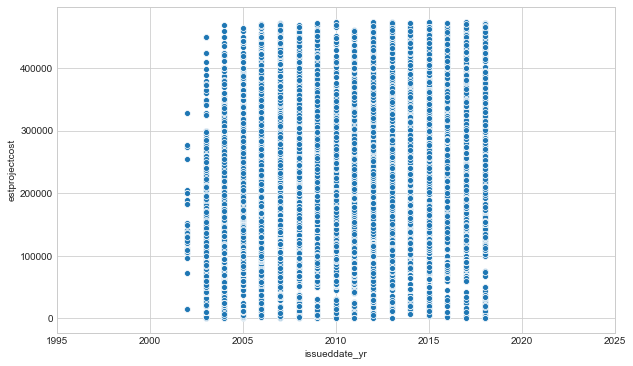

In [42]:
model_fitted_y = model_fit.fittedvalues
model_residuals = model_fit.resid
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
model_abs_resid = np.abs(model_residuals)
model_leverage = model_fit.get_influence().hat_matrix_diag
plt.figure(figsize=(10,6))
ax = sns.scatterplot(building_subset.issueddate_yr, building_subset.estprojectcost)
ax.set_xlim(1995,2025)

### <font color='green'>Analysis from graph </font>

From the above scattered plot I conclude that the data is not acceptable as linear. So we rule out the first assumption: there is a linear relationship between independent and dependent variable

### <font color='orange'>Assumption: Errors follow a normal distribution</font> 

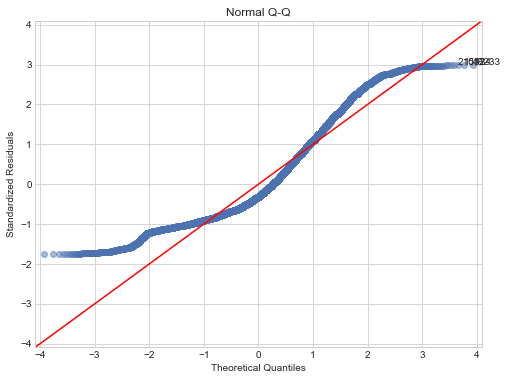

In [43]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(6)
plot_lm_2.set_figwidth(8)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

### <font color='green'>Analysis from Output </font>

The plot shows that the errors are not normally distributed (by looking at the curve extremes

### <font color='orange'>Assumption: Residuals have Equality of Variance </font> 

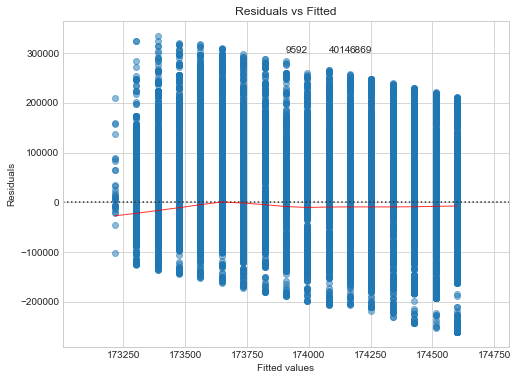

In [44]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(6)
plot_lm_1.set_figwidth(8)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, y_train.estprojectcost, data=y_train, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]));

### <font color='green'>Analysis from Output </font>

As we have many data points the residuals vs fitted is very broad and the errors are not normally distributed.
The assumption of equal variance can also be rejected.

# <font color='red'>FINAL ANALYSIS</font>

**With every increase in year the estimated project cost increases by 56.55 $**

    The column issueddate_yr is important in predicting the estprojectcost. Although, the estprojcost is directly             proportinal (positively related) to issueddate_yr (which means development & progress). It is not enough to rely on its predictions
    
   From the error metrics I conclude that **this model cannot be used to predict estprojectcost with least error** (Maybe by combining other features a roboust one can be created)


### 6. What additional techniques or methodologies could be used to improve the results from the previous step? 

I believe understanding all different columns, creating new features, using stronger predicition models (like Random Forest, Boosting algorithms) will increase likelihood of having less error model.

Also, addressing this as Time series might solve in predicting

In [45]:
cons_data["issueddate_yr"] = date_columns["issueddate_yr"]
cons_data[["issueddate_yr","estprojectcost"]].describe()

,issueddate_yr,estprojectcost
count,138519.000000,1.419530e+05
mean,2008.795176,1.920127e+05
std,5.486947,1.493678e+06
min,2000.000000,0.000000e+00
25%,2004.000000,1.000000e+04
50%,2008.000000,5.440400e+04
75%,2014.000000,1.350000e+05
max,2018.000000,1.700000e+08


### Few more Insights

    1. More number of sanctions in 8 years between 2000 to 2008 than from 2008 to 2018 which is 10 years
    2. The distribution plot shows that this column is highly skewed to right. Which means there are constructions
    that cost a lot more than others.


### Aspects to dig further
    1. NA value threshold can be taken as 3*IQR which is 158 thousand dollars instead of 200 thousand dollars
    2. plot the type of houses in a map with which we can strategically plan fire engine placement 
    3. Understand the outliers by looking at their values
    4. Do some NLP from the description and then new create formulas based on words to use it in model
    5. If the type of constructor has levels, like a specific team who work only on residential housing and other team only 
       on commercial construction etc.
    6. Some type of clustering based on location
    7. Create separate models for residential units and commercials
    8. Normalizing and using logarithmic transformations
    9. The type of Train test split.


Can use the following features:

    1. total sqft
    2. Number of stories
    3. parking space
    4. permit type
    5. street type
    6. work class
    7. construction type
    8. occupancy class constant 

GradientBoostingRegressor(alpha=0.01, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=4000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

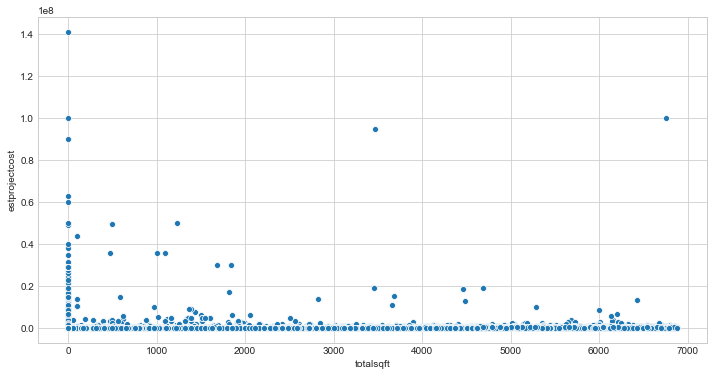

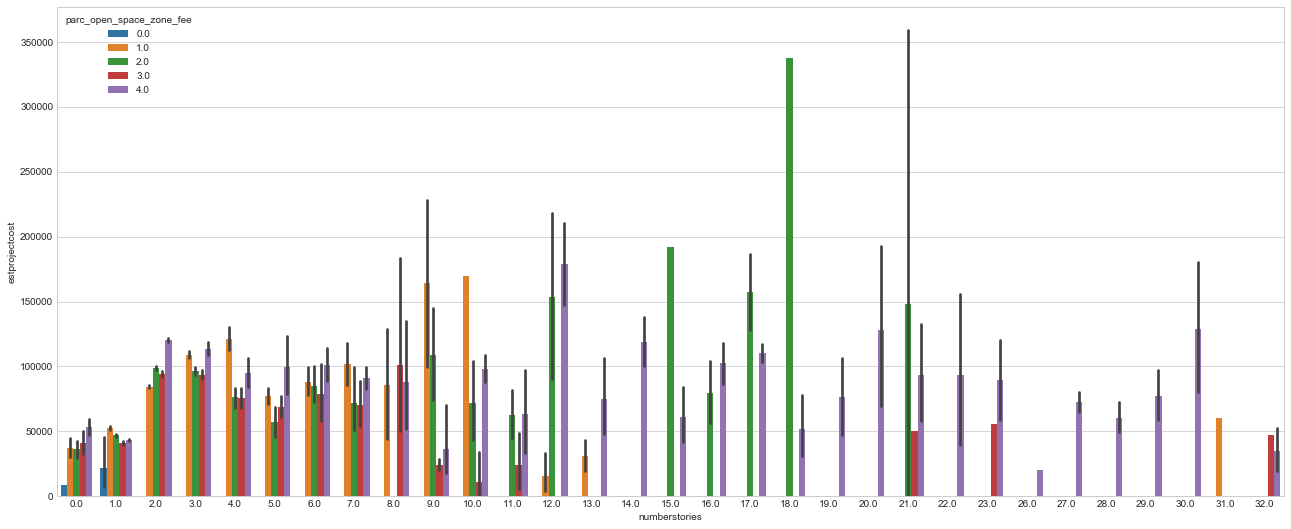

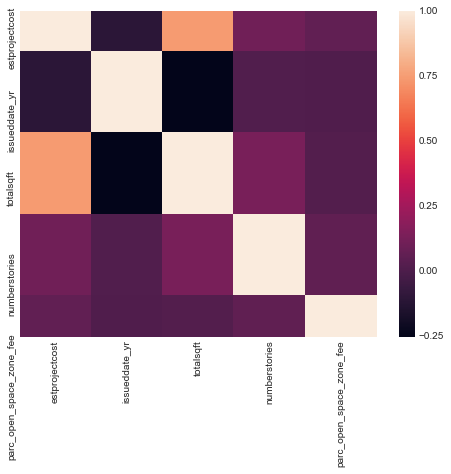

In [50]:
just_another_model = backup_data[["estprojectcost","issueddate_yr", "totalsqft", "numberstories",
                              "parc_open_space_zone_fee", "streettype",
                               "workclass", "const_type", "occupancyclass"]]

#Lets remove outliers
Q1 = just_another_model.totalsqft.quantile(0.25)
Q3 = just_another_model.totalsqft.quantile(0.75)
IQR = Q3 - Q1
just_another_model = just_another_model[just_another_model.totalsqft < 3*IQR]

#this has outliers, so lets remove them based on the z score
plt.figure(figsize=(12,6))
sns.scatterplot(just_another_model.totalsqft, just_another_model.estprojectcost)


just_another_model = just_another_model[just_another_model.numberstories < 33]

just_another_model.dropna(inplace=True)

#Lets remove outliers
Q1 = just_another_model.estprojectcost.quantile(0.25)
Q3 = just_another_model.estprojectcost.quantile(0.75)
IQR = Q3 - Q1
just_another_model = just_another_model[just_another_model.estprojectcost < 3*IQR]

plt.figure(figsize=(22,9))
sns.barplot(x=just_another_model.numberstories,  hue=just_another_model.parc_open_space_zone_fee,
            y= just_another_model.estprojectcost)


plt.figure(figsize=(8,6))
# calculate the correlation matrix
corr = just_another_model.corr()

# plot the heatmap
sns.heatmap(corr)

factors = ["streettype", "workclass", "const_type", "occupancyclass"]

for var in factors:
    just_another_model[var] = just_another_model[var].astype("category")
    
    
dummies_dataset = pd.get_dummies(just_another_model)


X = dummies_dataset.drop('estprojectcost',1)
y = dummies_dataset['estprojectcost']

#take fixed holdout set 30% of data rows
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.30,random_state=531)

from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
#initiating the gradient boosting with 4000 iterations and learning rate=0.01

gbm.fit(xTrain,yTrain)
#fittinng the model

In [52]:
just_another_model.numberstories.value_counts()

2.0     56730
1.0     36230
3.0      9592
4.0      1235
0.0      1201
5.0       974
6.0       549
7.0       390
17.0      228
10.0      202
14.0      110
12.0       94
16.0       78
29.0       70
28.0       69
11.0       53
15.0       50
8.0        34
9.0        33
32.0       28
21.0       26
19.0       26
13.0       25
18.0       19
30.0       14
23.0        9
20.0        8
22.0        7
27.0        2
26.0        1
31.0        1
Name: numberstories, dtype: int64

In [53]:
just_another_model.parc_open_space_zone_fee.value_counts()

4.0    33123
2.0    30026
1.0    29725
3.0    15210
0.0        4
Name: parc_open_space_zone_fee, dtype: int64

In [54]:
just_another_model.streettype.value_counts()

DR      30294
RD      16965
ST      15163
LN      10808
CT      10643
AVE      5808
WY       4293
PL       3788
BLVD     2149
WAY      2077
CIR      1977
TRL      1824
RUN       422
PKWY      421
WYND      170
SQ        154
MALL      133
          132
LOOP      115
TER       111
PT        108
PATH      100
CRES       83
CRSG       74
WALK       73
ALY        52
PARK       38
PLZ        28
ROW        25
CV         21
PASS       15
DOWN       10
KNL         5
LNDG        5
RDG         2
HL          1
TURN        1
Name: streettype, dtype: int64

In [55]:
just_another_model.workclass.value_counts()

New Building                       42566
Alterations/repairs                29229
Other                              13219
Addition                            9278
Interior Completion                 5213
Demolish                            3652
Detached Accessory Building         2163
Alterations To A Shell - No C O      969
Other - Resd                         852
Change Of Use                        250
Manufactured Home Replacement        130
Other - Comm                         119
Building Shell                       109
ALTERATIONS/REPAIRS                   82
Swimming Pool - Resd                  62
Manufactured Home Original            46
Cell Tower - Site                     42
INTERIOR COMPLETION                   33
Building Shell Addition               18
Cell Tower - Building                 14
NEW BUILDING                          12
Foundation Only                       11
Specialty                              8
Swimming Pool - Commercial             7
House Move      

In [56]:
just_another_model.const_type.value_counts()

V  B    76477
VI U    16096
II B     6894
I  B     1819
I  A     1368
IIIB     1291
II A     1264
V  A     1013
IV U     1004
VI P      180
II        178
IV P      147
V  U      115
IV         79
I          63
IIIA       57
V  P       29
III        14
Name: const_type, dtype: int64

In [57]:
just_another_model.occupancyclass.value_counts()

RESIDENT 3  SFD/DUP     68578
RESIDENT-SFD/DUPLEX     11883
BUSINESS                 8513
RESIDENTIAL 2            6301
GROUP HOUSING            3681
MERCANTILE               2198
UTILITY                  1515
ASSEMBLY 2               1327
ASSEMBLY 3                762
STORAGE 1                 748
EDUCATIONAL               669
INSTITUTIONAL 2           470
STORAGE 2                 424
RESIDENTIAL 1             221
FACTORY 1                 200
RESIDENTIAL 4             118
ASSEMBLY SMALL            100
ASSEMBLY 1                 77
INSTITUTIONAL              59
ASSEMBLY 4                 58
FACTORY 2                  49
ASSEMBLY 5                 47
FACTORY/INDUSTRIAL         22
ASSEMBLY LARGE             20
INSTITUTIONAL 1            17
INSTITUTIONAL 4             9
HAZARDOUS 2                 7
INSTITUTIONAL 3             7
HAZARDOUS 3                 4
HAZARDOUS 1                 2
HAZARDOUS 4                 1
A2 REST,BAR,BANQHALL        1
Name: occupancyclass, dtype: int64

In [48]:
just_another_model.isna().sum()

estprojectcost                  0
issueddate_yr                3434
totalsqft                    5252
numberstories               19511
parc_open_space_zone_fee        4
streettype                     11
workclass                     360
const_type                   7862
occupancyclass               6589
dtype: int64

In [51]:
#Model Error
y_train_pred = gbm.predict(xTrain)
y_test_pred = gbm.predict(xTest)
print('Mean Squared Error of GBM on train dataset :', metrics.mean_squared_error(yTrain, y_train_pred)) 
print('Mean Squared Error of GBMon test dataset :', metrics.mean_squared_error(yTest, y_test_pred)) 

Mean Squared Error of GBM on train dataset : 1125513024.294395
Mean Squared Error of GBMon test dataset : 1490281399.6429393


In [ ]:

col_names = np.array(list(just_another_model))

#take fixed holdout set 30% of data rows
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.30,random_state=531)
# Train Gradient Boosting model to minimize mean squared error
nEst = 200
depth = 7
learnRate = 0.01
subSamp = 0.5
consGBModel = ensemble.GradientBoostingRegressor(n_estimators=nEst,
                                                  max_depth=depth,
                                                  learning_rate=learnRate,
                                                  subsample = subSamp,
                                                  loss='ls')

consGBModel.fit(xTrain, yTrain)

# compute mse on test set
msError = []
predictions = consGBModel.staged_predict(xTest)

for p in predictions:
    msError.append(mean_squared_error(yTest, p))

print("MSE:",min(msError) )

### <font color='green'>Some Interactive Plotting using Bokeh </font>
Scroll the year bar at the output below the plot to change year


X-axis is the value of the estimated project cost and Y-axis shows the number of stories
The size of bubble shows the total sqft area. So the bigger the area the more will be the bubble.
THe color shows the type of fire resistance level.

Although this is still in development and right now I cannot infer much about the plot.
It has to be fine tuned by understanding different attributes in the dataset and then even more sensible plot can be drawn
#### The year bar below the plot can be changed to view different cost values in each year


In [ ]:
data = pd.read_csv('Building_Permits.csv', low_memory=False)

In [58]:
data = backup_data
data = data[["issueddate_yr","estprojectcost","statuscurrent","totalsqft","statuscurrentmapped", "workclass",
                 "numberstories","const_type","proposeduse","occupancyclass",
            "countylocation"]]

data = data[np.isfinite(data['issueddate_yr'])]
data.set_index("issueddate_yr",inplace=True)

data = data[(data.numberstories < 32) | (data.estprojectcost < 40000)]
data = data.dropna()
data['roman_letter'] = data['const_type'].str.split(' ').str[0]

j = []
for i in data.roman_letter:
    if (len(i)>3):
        j.append(i[0:3])
    else:
        j.append(i)
        
data['roman_letter'] = j
data["year"] = data.index

sum_df = data.groupby(['year','roman_letter','statuscurrentmapped',"workclass"]).agg({'estprojectcost': 'sum',
                                                                                           'totalsqft': 'sum','numberstories':'sum'})
sum_df = sum_df.reset_index()
sum_df.set_index("year", inplace=True,drop=True)
sum_df['totalsqft'] = sum_df.totalsqft
sum_df = sum_df[(sum_df.totalsqft < 2893) & (sum_df.numberstories < 4)]
data = sum_df


size_mapper = LinearInterpolator(x=[data.totalsqft.min(), data.totalsqft.max()], y = [5,50])

source = ColumnDataSource(dict(
    x= data.loc[2012].estprojectcost,  
    y= data.loc[2012].numberstories,   
    totalsqft = data.loc[2012].totalsqft,
    statuscurrentmapped = data.loc[2010].statuscurrentmapped,
    roman_letter = data.loc[2012].roman_letter,
#     contractorstate = data.loc[2012].contractorstate,
    workclass =  data.loc[2012].workclass,
    ))

def update (year):
    new_data = dict(
        x= data.loc[year].estprojectcost,
        y=data.loc[year].numberstories,
        totalsqft = data.loc[year].totalsqft,
        statuscurrentmapped = data.loc[year].statuscurrentmapped,
        roman_letter = data.loc[year].roman_letter,
#         contractorstate = data.loc[year].contractorstate,
        workclass = data.loc[year].workclass
    )
    source.data = new_data 
    p.title.text = str(year) 
    push_notebook()



color_mapper = CategoricalColorMapper(
   factors = list(data.roman_letter.unique()),  
  palette = Spectral6)


hover = HoverTool(tooltips = [("Fire_safety_level","@roman_letter"),
                              ("statuscurrentmapped", "@statuscurrentmapped"),
                              ("contractorstate","@contractorstate"),
                              ("estprojectcost", "@x"),
                              ("totalsqft", "@totalsqft"),
                              ("numberstories", "@y"), 
                              ("workclass","@workclass"),],
                  show_arrow=False)
PLOT_OPTS = dict(
    height =300, 
    x_axis_type='log',
    x_range=(1000,400000),
    y_range=[0, 5])


p = figure(title = str('Number of stories vs Estimated cost'),toolbar_location='above', 
    title_location = 'above',
    tools=[hover],
    **PLOT_OPTS)
p.circle(
    x='x',y='y', 
    size={'field':'totalsqft', 'transform': size_mapper},  
    color = {'field':'roman_letter','transform':color_mapper}, 
    legend='roman_letter',
    source=source,  
    alpha=0.6) 

p.legend.title = 'Fire resistance level'
p.xaxis[0].formatter = NumeralTickFormatter(format='0$,')
p.right.append(p.legend[0]) 
show(p, notebook_handle=True) 
interact(update, year=(2000,2018,1))

interactive(children=(IntSlider(value=2009, description='year', max=2018, min=2000), Output()), _dom_classes=(…

<function __main__.update(year)>